In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
#validation dataset
val = pd.read_csv("twitter_validation.csv", header=None)

#training dataset
train = pd.read_csv("twitter_training.csv", header=None)

In [4]:
train.columns=['id', 'information','type', 'text']
train.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
val.columns=['id','information','type','text']
val.head()

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [6]:
train_data = train
train_data

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [7]:
val_data = val
val_data

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [8]:
#Text transformation
import re

train_data["lower"]=train_data.text.str.lower() #lowercasing
train_data["lower"]=[str(data) for data in train_data.lower] #converting all to string
train_data["lower"]=train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

val_data["lower"]=val_data.text.str.lower() #lowercasing
val_data["lower"]=[str(data) for data in val_data.lower] #converting all to string
val_data["lower"]=val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

In [9]:
train_data.head()
#val_data.head()

,id,information,type,text,lower
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


In [10]:
# Function to clean data
def clean_data(df):
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Remove rows with NaN values in 'text' or 'sentiment' columns
    df = df.dropna(subset=['text', 'type'])
    
    # Replace any remaining NaN values in 'text' with an empty string
    df.loc[:, 'text'] = df['text'].fillna('')
    
    return df

In [11]:
# Clean the datasets
train_data = clean_data(train_data)
val_data = clean_data(val_data)

In [12]:
# Print dataset sizes after cleaning
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 73996
Validation set size: 1000


In [13]:
# Prepare the datasets
X_train, y_train = train_data['text'], train_data['type']
X_val, y_val = val_data['text'], val_data['type']
print(X_train)

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: text, Length: 73996, dtype: object


In [27]:
# Feature extraction
vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.95)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

In [31]:
# Define models and parameters
models = {
    'Naive Bayes': (MultinomialNB(), {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
    }),
    'SVM': (LinearSVC(), {
        'C': [0.1, 0.5, 1, 5, 10],
        'max_iter': [2000]
    })
}

In [32]:
# Dictionary to store results
results = {}

In [43]:
def compare_and_select_best_model(results):
    """Compare models and select the best one based on validation metrics"""
    model_comparison = {}
    
    for name, result in results.items():
        # Calculate validation metrics
        val_metrics = {
            'accuracy': accuracy_score(y_val, result['val_pred']),
            'precision': precision_score(y_val, result['val_pred'], average='weighted'),
            'recall': recall_score(y_val, result['val_pred'], average='weighted'),
            'f1': f1_score(y_val, result['val_pred'], average='weighted')
        }
        model_comparison[name] = val_metrics
    
    # Create comparison visualization
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(metrics))
    width = 0.35
    
    # Plot bars for each model
    for i, (name, metrics_dict) in enumerate(model_comparison.items()):
        values = [metrics_dict[metric] for metric in metrics]
        plt.bar(x + (i-0.5)*width, values, width, label=name)
    
    plt.ylabel('Score')
    plt.title('Model Comparison - All Metrics')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0, 1)
    
    # Add value labels
    for i, (name, metrics_dict) in enumerate(model_comparison.items()):
        for j, value in enumerate([metrics_dict[metric] for metric in metrics]):
            plt.text(j + (i-0.5)*width, value + 0.01, f'{value:.3f}', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Select best model based on F1 score
    best_model_name = max(model_comparison.items(), 
                         key=lambda x: x[1]['f1'])[0]
    
    print(f"\nModel Comparison Summary:")
    for name, metrics_dict in model_comparison.items():
        print(f"\n{name}:")
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best validation F1 score: {model_comparison[best_model_name]['f1']:.4f}")
    
    return results[best_model_name]['model']

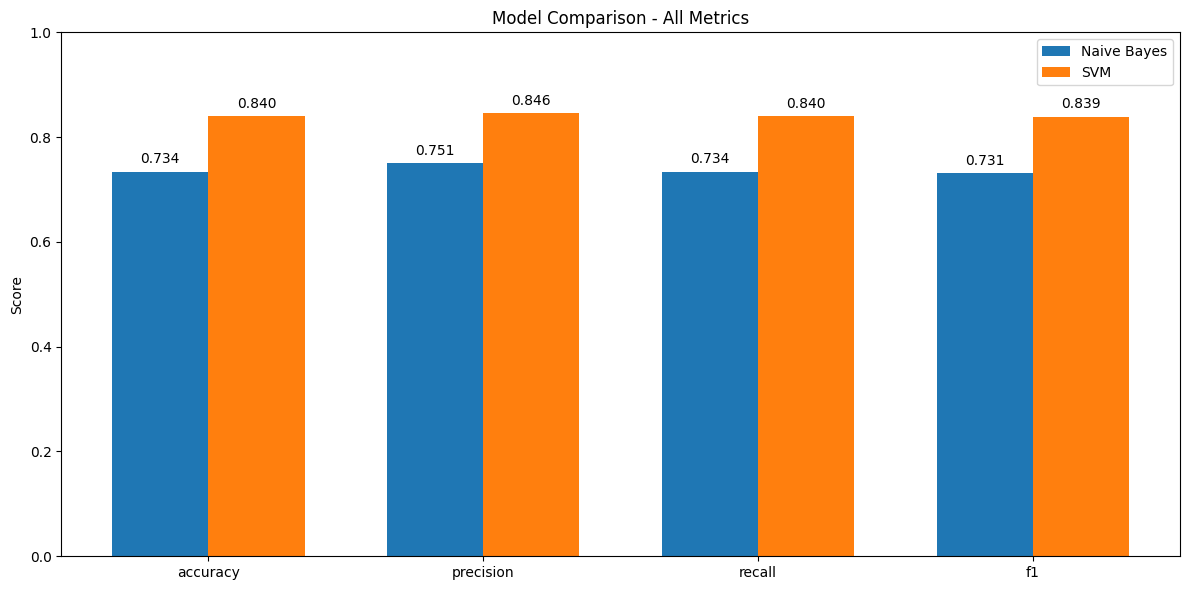


Model Comparison Summary:

Naive Bayes:
accuracy: 0.7340
precision: 0.7511
recall: 0.7340
f1: 0.7310

SVM:
accuracy: 0.8400
precision: 0.8458
recall: 0.8400
f1: 0.8391

Best performing model: SVM
Best validation F1 score: 0.8391


In [44]:
# Use the new comparison function
best_model = compare_and_select_best_model(results)

In [45]:
#Confusion Matrix Function
def plot_confusion_matrices(results):
    """Plot confusion matrices for both models side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Naive Bayes Confusion Matrix
    cm_nb = confusion_matrix(y_val, results['Naive Bayes']['val_pred'])
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix - Naive Bayes')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # SVM Confusion Matrix
    cm_svm = confusion_matrix(y_val, results['SVM']['val_pred'])
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix - SVM')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

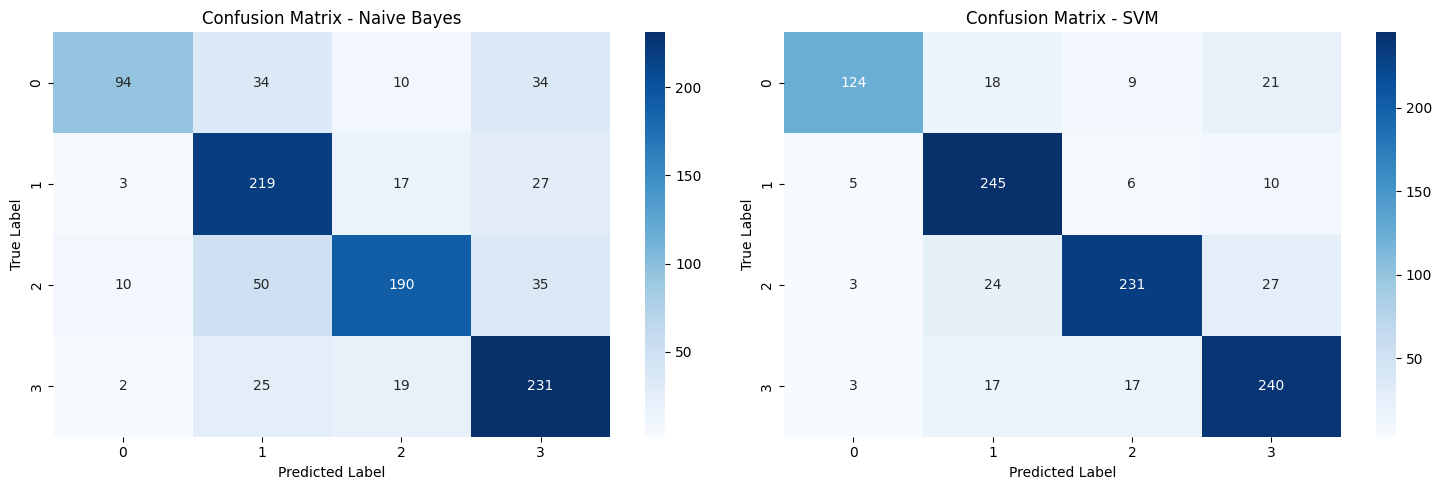

In [46]:
# Plot Confusion Matrices
plot_confusion_matrices(results)

In [47]:
# Model Metrics Comparison Function
def plot_metrics_comparison(results):
    """Plot comparison of all metrics between models"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Calculate metrics for both models
    nb_scores = [
        accuracy_score(y_val, results['Naive Bayes']['val_pred']),
        precision_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),
        recall_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),
        f1_score(y_val, results['Naive Bayes']['val_pred'], average='weighted')
    ]
    
    svm_scores = [
        accuracy_score(y_val, results['SVM']['val_pred']),
        precision_score(y_val, results['SVM']['val_pred'], average='weighted'),
        recall_score(y_val, results['SVM']['val_pred'], average='weighted'),
        f1_score(y_val, results['SVM']['val_pred'], average='weighted')
    ]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    rects1 = plt.bar(x - width/2, nb_scores, width, label='Naive Bayes', color='lightblue')
    rects2 = plt.bar(x + width/2, svm_scores, width, label='SVM', color='lightgreen')
    
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0, 1)
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()


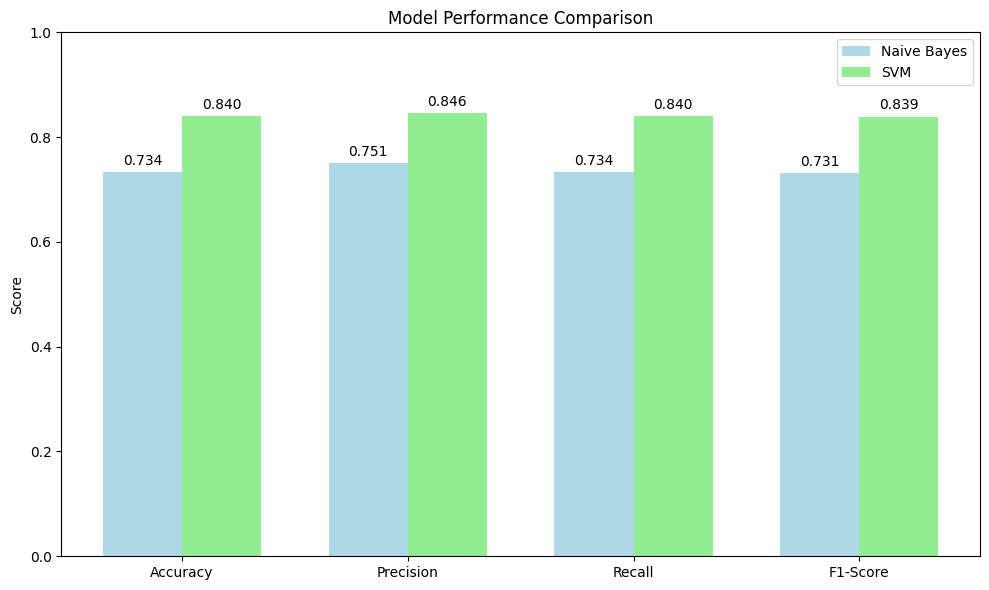

In [48]:
# Plot Metrics Comparison
plot_metrics_comparison(results)

In [49]:
# Training vs Validation Comparison Function
def plot_train_val_comparison(results):
    """Plot training vs validation F1-scores for both models"""
    # Calculate F1-scores
    train_scores = [
        f1_score(y_train, results['Naive Bayes']['train_pred'], average='weighted'),
        f1_score(y_train, results['SVM']['train_pred'], average='weighted')
    ]
    val_scores = [
        f1_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),
        f1_score(y_val, results['SVM']['val_pred'], average='weighted')
    ]
    
    # Create plot
    plt.figure(figsize=(8, 6))
    x = np.arange(2)
    width = 0.35
    
    plt.bar(x - width/2, train_scores, width, label='Training', color='lightcoral')
    plt.bar(x + width/2, val_scores, width, label='Validation', color='lightseagreen')
    
    plt.ylabel('F1-Score')
    plt.title('Training vs Validation F1-Scores')
    plt.xticks(x, ['Naive Bayes', 'SVM'])
    plt.legend()
    plt.ylim(0, 1)
    
    # Add value labels
    for i, score in enumerate(train_scores):
        plt.text(i - width/2, score + 0.01, f'{score:.3f}', ha='center')
    for i, score in enumerate(val_scores):
        plt.text(i + width/2, score + 0.01, f'{score:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()

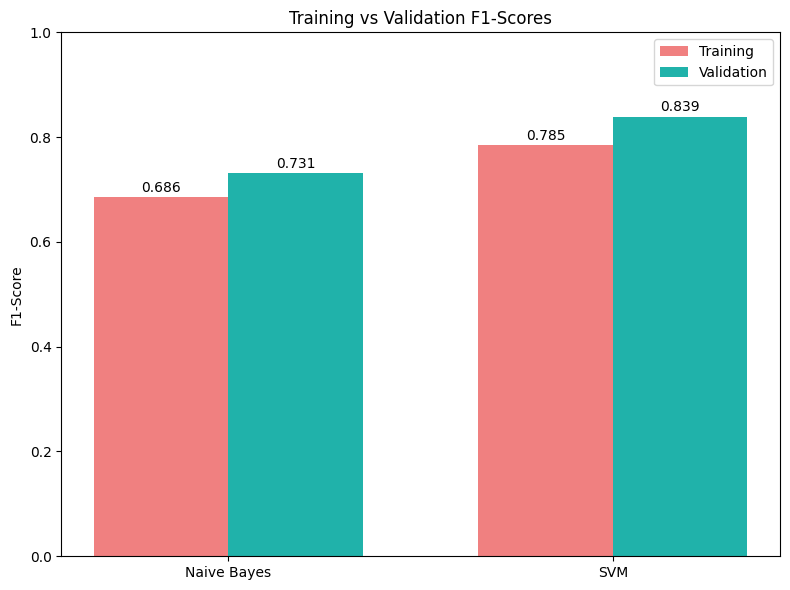

In [50]:
# Plot Training vs Validation Comparison
plot_train_val_comparison(results)

In [62]:
# Print Detailed Comparison
def print_detailed_comparison(results):
    """Print detailed numerical comparison of models"""
    train_scores = [
        accuracy_score(y_train, results['Naive Bayes']['train_pred']),
        precision_score(y_train, results['Naive Bayes']['train_pred'], average='weighted'),
        recall_score(y_train, results['Naive Bayes']['train_pred'], average='weighted'),
        f1_score(y_train, results['Naive Bayes']['train_pred'], average='weighted'),

        accuracy_score(y_train, results['SVM']['train_pred']),
        precision_score(y_train, results['SVM']['train_pred'], average='weighted'),
        recall_score(y_train, results['SVM']['train_pred'], average='weighted'),
        f1_score(y_train, results['SVM']['train_pred'], average='weighted')
    ]
    val_scores = [
        accuracy_score(y_val, results['Naive Bayes']['val_pred']),
        precision_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),
        recall_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),
        f1_score(y_val, results['Naive Bayes']['val_pred'], average='weighted'),

        accuracy_score(y_val, results['SVM']['val_pred']),
        precision_score(y_val, results['SVM']['val_pred'], average='weighted'),
        recall_score(y_val, results['SVM']['val_pred'], average='weighted'),
        f1_score(y_val, results['SVM']['val_pred'], average='weighted')
    ]
    
    print("Detailed Model Comparison:")
    print("\nNaive Bayes for Training Data:")
    print(f"Accuracy: {train_scores[0]:.4f}")
    print(f"Precision: {train_scores[1]:.4f}")
    print(f"Recall: {train_scores[2]:.4f}")
    print(f"F1-Score: {train_scores[3]:.4f}")
    print("\nNaive Bayes for Validation Data:")
    print(f"Accuracy: {val_scores[0]:.4f}")
    print(f"Precision: {val_scores[1]:.4f}")
    print(f"Recall: {val_scores[2]:.4f}")
    print(f"F1-Score: {val_scores[3]:.4f}")
    print(f"Difference (Training - Validation): {train_scores[3] - val_scores[3]:.4f}")
    
    print("\nSVM for Training Data:")
    print(f"Accuracy: {train_scores[4]:.4f}")
    print(f"Precision: {train_scores[5]:.4f}")
    print(f"Recall: {train_scores[6]:.4f}")
    print(f"F1-Score: {train_scores[7]:.4f}")
    print("\nSVM for Validation Data:")
    print(f"Accuracy: {val_scores[4]:.4f}")
    print(f"Precision: {val_scores[5]:.4f}")
    print(f"Recall: {val_scores[6]:.4f}")
    print(f"F1-Score: {val_scores[7]:.4f}")
    print(f"Difference (Training - Validation): {train_scores[7] - val_scores[7]:.4f}")

In [63]:
# Print Detailed Comparison
print_detailed_comparison(results)

Detailed Model Comparison:

Naive Bayes for Training Data:
Accuracy: 0.6938
Precision: 0.7078
Recall: 0.6938
F1-Score: 0.6858

Naive Bayes for Validation Data:
Accuracy: 0.7340
Precision: 0.7511
Recall: 0.7340
F1-Score: 0.7310
Difference (Training - Validation): -0.0451

SVM for Training Data:
Accuracy: 0.7874
Precision: 0.7903
Recall: 0.7874
F1-Score: 0.7854

SVM for Validation Data:
Accuracy: 0.8400
Precision: 0.8458
Recall: 0.8400
F1-Score: 0.8391
Difference (Training - Validation): -0.0537


In [53]:
joblib.dump(best_model, 'sentiment_analysis_model-v3.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer-v3.joblib')

['tfidf_vectorizer-v3.joblib']

In [54]:
# Load the trained model and vectorizer
model = joblib.load('sentiment_analysis_model-v3.joblib')
vectorizer = joblib.load('tfidf_vectorizer-v3.joblib')

In [55]:
def predict_sentiment(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return "Neutral"  # Return neutral for empty, NaN, or non-string input
    vectorized_text = vectorizer.transform([text])
    prediction = model.predict(vectorized_text)[0]
    return prediction

In [56]:
def get_sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    elif sentiment == 'Neutral':  # Neutral
        return 0

In [57]:
def analyze_post_sentiment(post_description, comments):
    # Ensure post_description is a string
    post_description = str(post_description) if post_description is not None else ""
    
    # Analyze post description
    post_sentiment = predict_sentiment(post_description)
    post_score = get_sentiment_score(post_sentiment)
    
    # Ensure comments is a list and remove any None values
    comments = [str(comment) for comment in (comments or []) if comment is not None]
    
    # Analyze comments
    comment_sentiments = [predict_sentiment(comment) for comment in comments if comment.strip()]
    comment_scores = [get_sentiment_score(sentiment) for sentiment in comment_sentiments]
    
    # Calculate average sentiment score
    all_scores = [post_score] + comment_scores
    average_score = sum(all_scores) / len(all_scores) if all_scores else 0
    
    # Determine overall sentiment based on average score
    if average_score > 0.3:
        overall_sentiment = 'Positive'
    elif average_score < -0.3:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'
    
    return {
        'post_sentiment': post_sentiment,
        'comment_sentiments': comment_sentiments,
        'average_score': average_score,
        'overall_sentiment': overall_sentiment
    }

In [60]:
# Example usage
post_description = "The streetlight has been fixed quickly. Great job!"

comments = [
    
]

In [61]:
result = analyze_post_sentiment(post_description, comments)
print(f"Post Sentiment: {result['post_sentiment']}")
print(f"Comment Sentiments: {result['comment_sentiments']}")
print(f"Average Sentiment Score: {result['average_score']:.2f}")
print(f"Overall Sentiment: {result['overall_sentiment']}")

Post Sentiment: Positive
Comment Sentiments: []
Average Sentiment Score: 1.00
Overall Sentiment: Positive
